# 1. Exploratory Analysis of the Dataset

## Disinformation Dataset

### Dataset exploration and preparation

The file en-scheme-annotations.json contains structured annotation data about Twitter conversations related to major real-world events such as Charlie Hebdo, Ferguson, Germanwings crash, Ottawa shooting, Sydney siege, Putin missing, and others. 

Each entry represents a tweet annotated with metadata fields including **event** (the associated incident), **threadid** and **tweetid** (unique identifiers linking tweets to conversation threads), **support** (indicating whether the tweet supports, denies, or is neutral toward a claim), **evidentiality** (the type of evidence cited, such as a URL, quoted source, or witness account), and **certainty** (the annotator’s confidence level, e.g., certain, somewhat-certain, or uncertain). The reply tweets include **responsetype-vs-source** and **responsetype-vs-previous** describing the nature of a reply (e.g., comment, agreed, disagreed, or appeal-for-more-information). This dataset is designed for studying rumor verification, stance detection, and information credibility across social media discussions.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from wordcloud import WordCloud
import re

df = pd.read_json("training_data/phemerumourschemedataset/annotations/en-scheme-annotations.json", lines=True)

In [9]:
import sys
!{sys.executable} -m pip install wordcloud


To understandd better the structure and the entries of the dataframe, let's do some simple analysis :

First of all, in this dataset, we have three different types of entries: tweets, replies to tweets, and deep replies (which correspond to replies to replies).

Tweets do not contain the fields **responsetype-vs-source** or **responsetype-vs-previous**, since they are not responding to anything.

Replies contain the **responsetype-vs-source** field, which indicates the stance of the reply relative to the original tweet.

Deep replies contain both **responsetype-vs-source** and **responsetype-vs-previous**, so we can know the stance of the reply relative to the original tweet as well as relative to the preceding reply.

For example:

In [11]:
print("Tweet entry example")
print(df.loc[1])

print("\n")

print("Reply entry example")
print(df.loc[300])

print("\n")

print("Deep reply entry example")
print(df.loc[4300])


Tweet entry example
event                             putinmissing
threadid                    576755174531862528
tweetid                     576755174531862528
support                             supporting
evidentiality                        url-given
certainty                     somewhat-certain
responsetype-vs-source                     NaN
responsetype-vs-previous                   NaN
Name: 1, dtype: object


Reply entry example
event                             putinmissing
threadid                    577258317942149120
tweetid                     577284294051123200
support                                    NaN
evidentiality                              NaN
certainty                                  NaN
responsetype-vs-source                 comment
responsetype-vs-previous                   NaN
Name: 300, dtype: object


Deep reply entry example
event                                 ferguson
threadid                    500347114975944704
tweetid                     500355271

We can then analyze the number of entries:

In [12]:
df.count()

event                       4560
threadid                    4560
tweetid                     4560
support                      297
evidentiality               2020
certainty                   2020
responsetype-vs-source      4263
responsetype-vs-previous    1654
dtype: int64

The fields **event**, **threadid**, and **tweetid** are shared by all tweet types. We therefore have a total of 4,560 entries.

More precisely:
 - **support** appears 297 times => 297 tweets
 - **responsetype-vs-previous** appears 1,654 times => 1,654 deep replies
 - For the number of replies, we look for all entries with a non-null value for **responsetype-vs-source**, but a null value for **responsetype-vs-previous**:


In [13]:
replies = df[(df['responsetype-vs-source'].notna()) & (df['responsetype-vs-previous'].isna())].shape[0]
print("Number of replies : ", replies)

Number of replies :  2609


Some types informations :

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   event                     4560 non-null   object
 1   threadid                  4560 non-null   int64 
 2   tweetid                   4560 non-null   int64 
 3   support                   297 non-null    object
 4   evidentiality             2020 non-null   object
 5   certainty                 2020 non-null   object
 6   responsetype-vs-source    4263 non-null   object
 7   responsetype-vs-previous  1654 non-null   object
dtypes: int64(2), object(6)
memory usage: 285.1+ KB


Our study focuses on misinformation, so we need to know whether each tweet contains true or false information.

We therefore perform a join to add the **misinformation** column, as well as the content of tweets and replies.


In [15]:
data_list = []

base_path = "training_data/phemerumourschemedataset/threads/en"

# Iterate over each thematic folder
for event_folder in os.listdir(base_path):
    event_path = os.path.join(base_path, event_folder)
    
    # Check that it is indeed a folder (not a file)
    if os.path.isdir(event_path):
        
        # Iterate over each thread in this thematic folder
        for thread_folder in os.listdir(event_path):
            thread_path = os.path.join(event_path, thread_folder)
            annotation_path = os.path.join(thread_path, "annotation.json")
            
            if os.path.isfile(annotation_path):
                with open(annotation_path, "r") as f:
                    annotation_data = json.load(f)
                    
                    # Add the event and threadid for merging
                    annotation_data["event"] = event_folder
                    annotation_data["threadid"] = int(thread_folder)
                    
                    data_list.append(annotation_data)

# Convert to DataFrame
df_threads = pd.DataFrame(data_list)

# Merge with the main DataFrame
df_merged = pd.merge(df, df_threads, on=["event", "threadid"], how="left")


In [16]:
df_merged = pd.merge(df, df_threads, on="threadid", how="left")

We join the content of the tweets.

In [17]:
base_path = "training_data/phemerumourschemedataset/threads/en"  
source_list = []

for event_folder in os.listdir(base_path):
    event_path = os.path.join(base_path, event_folder)
    
    if os.path.isdir(event_path):
        for thread_folder in os.listdir(event_path):
            thread_path = os.path.join(event_path, thread_folder)

            # Path to the text file
            source_tweet_path = os.path.join(thread_path, "source-tweets", f"{thread_folder}.json")

            if os.path.isfile(source_tweet_path):
                with open(source_tweet_path, "r") as f:
                    data = json.load(f)
                    source_list.append({
                        "event": event_folder,
                        "threadid": int(thread_folder),
                        "text": data.get("text", None)
                    })

df_sources = pd.DataFrame(source_list)

In [18]:
df_merged = pd.merge(df_merged, df_sources, on=["threadid"], how="left")

We remove the fields that are not needed for training:

In [19]:
df_merged = df_merged.drop(columns=["is_turnaround", "event_y", "true", "event"])

For several tweets, the dataset does not indicate whether they contain true or false information. We therefore need to remove the tweet along with all associated replies, as they would be useless for model training.


In [20]:
missing_misinfo = df_merged['misinformation'].isna().sum()
print("Number of tweets/replies without misinformation label:", missing_misinfo)

Number of tweets/replies without misinformation label: 1503


In [21]:
df = df_merged[df_merged['misinformation'].notna()].copy()

Here is the dataframe ready for use

In [22]:
df.head()

,event_x,threadid,tweetid,support,evidentiality,certainty,responsetype-vs-source,responsetype-vs-previous,is_rumour,category,misinformation,links,text
0,putinmissing,577258317942149120,577258317942149120,supporting,url-given,somewhat-certain,NaN,NaN,rumour,"Putin is facing a ""palace coup""",0,[{'link': 'http://www.forbes.com/sites/katyaso...,Was Vladimir Putin netralized by an internal c...
2,putinmissing,576319832800555008,576319832800555008,supporting,url-given,somewhat-certain,NaN,NaN,rumour,Putin's girlfriend is giving birth to their ch...,0,[{'link': 'http://www.express.co.uk/news/world...,Hoppla! @L0gg0l: Swiss Rumors: Putin absence d...
4,charliehebdo,552783667052167168,552783667052167168,supporting,url-given,certain,NaN,NaN,rumour,(At least) 10 people are dead at Charlie Hebdo...,0,[{'link': 'http://www.bbc.co.uk/news/live/worl...,France: 10 people dead after shooting at HQ of...
5,charliehebdo,552793679082311680,552793679082311680,supporting,url-given,certain,NaN,NaN,rumour,11 people died during the Charlie Hebdo attack,0,[{'link': 'https://amp.twimg.com/v/29607592-21...,"11 confirmed dead, Francois Hollande to visit ..."
6,charliehebdo,553548567420628992,553548567420628992,supporting,source-quoted,somewhat-certain,NaN,NaN,rumour,At least two dead in hostage-taking in Porte d...,0,[{'link': 'http://time.com/3661159/charlie-heb...,"AFP reports there are 2 dead, and 5 hostages b..."


### Basic analysis of the data

**Class distribution analysis :**

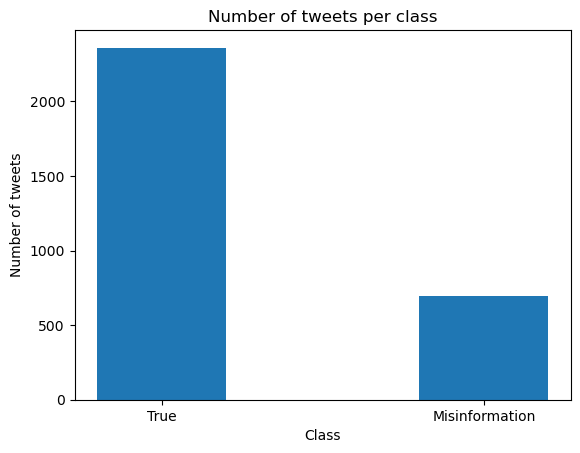

In [23]:
# Convert to integer
df['misinformation'] = df['misinformation'].astype(int)

# Count the number of tweets per class
counts = df['misinformation'].value_counts()

plt.bar(['True', 'Misinformation'], counts, width=0.4)
plt.xlabel('Class')
plt.ylabel('Number of tweets')
plt.title('Number of tweets per class')
plt.show()


**Text lenght :**

count    3057.000000
mean      121.180242
std        20.767282
min        41.000000
25%       111.000000
50%       129.000000
75%       138.000000
max       144.000000
Name: text_length, dtype: float64


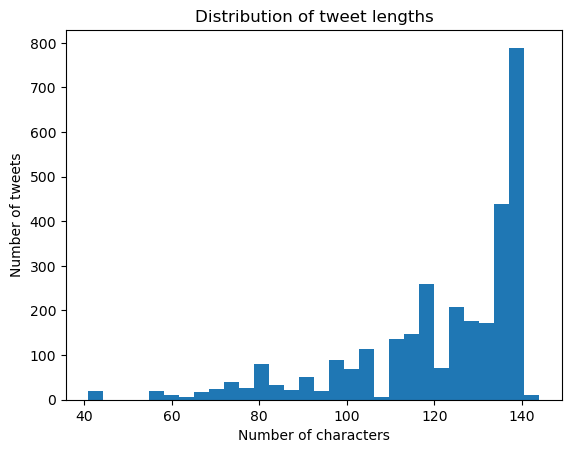

In [24]:
# Length in characters
df['text_length'] = df['text'].apply(len)

# Descriptive statistics
print(df['text_length'].describe())

plt.hist(df['text_length'], bins=30)
plt.xlabel('Number of characters')
plt.ylabel('Number of tweets')
plt.title('Distribution of tweet lengths')
plt.show()


**Text length by class :**

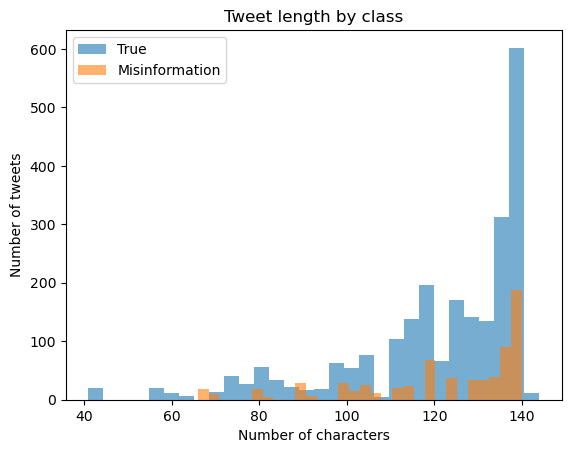

In [25]:
# Text length
df['text_length'] = df['text'].apply(len)

# Separate the classes
real = df[df['misinformation'] == 0]
misinfo = df[df['misinformation'] == 1] 


plt.hist(real['text_length'], bins=30, alpha=0.6, label='True')
plt.hist(misinfo['text_length'], bins=30, alpha=0.6, label='Misinformation')

plt.xlabel('Number of characters')
plt.ylabel('Number of tweets')
plt.title('Tweet length by class')
plt.legend()
plt.show()


**Most frequent words by class :**

In [26]:
# Convert the 'text' column of real and misinformation tweets into lists
tweetsReal = real['text'].values.tolist()
tweetsMisinfo = misinfo['text'].values.tolist()

dReal = {}
dMisinfo = {}

# Count word frequencies for real tweets
for tweet in tweetsReal:
    words = tweet.split()
    for word in words:
        if word not in dReal:
            dReal[word] = 1
        else:
            dReal[word] += 1

# Count word frequencies for misinformation tweets
for tweet in tweetsMisinfo:
    words = tweet.split()
    for word in words:
        if word not in dMisinfo:
            dMisinfo[word] = 1
        else:
            dMisinfo[word] += 1

# Sort the dictionaries by frequency in descending order
dReal_sorted = dict(sorted(dReal.items(), key=lambda item: item[1], reverse=True))
dMisinfo_sorted = dict(sorted(dMisinfo.items(), key=lambda item: item[1], reverse=True))

# Print the top 20 most frequent words in real tweets
compteur = 0
print("Real")
for cle, valeur in dReal_sorted.items():
    print(cle, ":", valeur)
    compteur += 1
    if compteur == 20:
        break

# Print the top 20 most frequent words in misinformation tweets
compteur = 0
print("\n")
print("Misinformation")
for cle, valeur in dMisinfo_sorted.items():
    print(cle, ":", valeur)
    compteur += 1
    if compteur == 20:
        break


Real
in : 1248
to : 1025
the : 927
of : 908
#Ferguson : 629
a : 527
are : 428
at : 393
for : 372
Sydney : 357
police : 337
and : 321
from : 301
on : 279
is : 262
hostages : 255
was : 255
Police : 251
- : 249
robbery : 249


Misinformation
in : 293
to : 187
at : 158
are : 132
of : 118
be : 116
on : 111
and : 103
the : 102
War : 102
Parliament : 97
reports : 96
a : 93
#CharlieHebdo : 92
after : 86
Police : 84
police : 82
#Ottawa : 79
Hill, : 79
Memorial, : 79


**Wordcloud :**

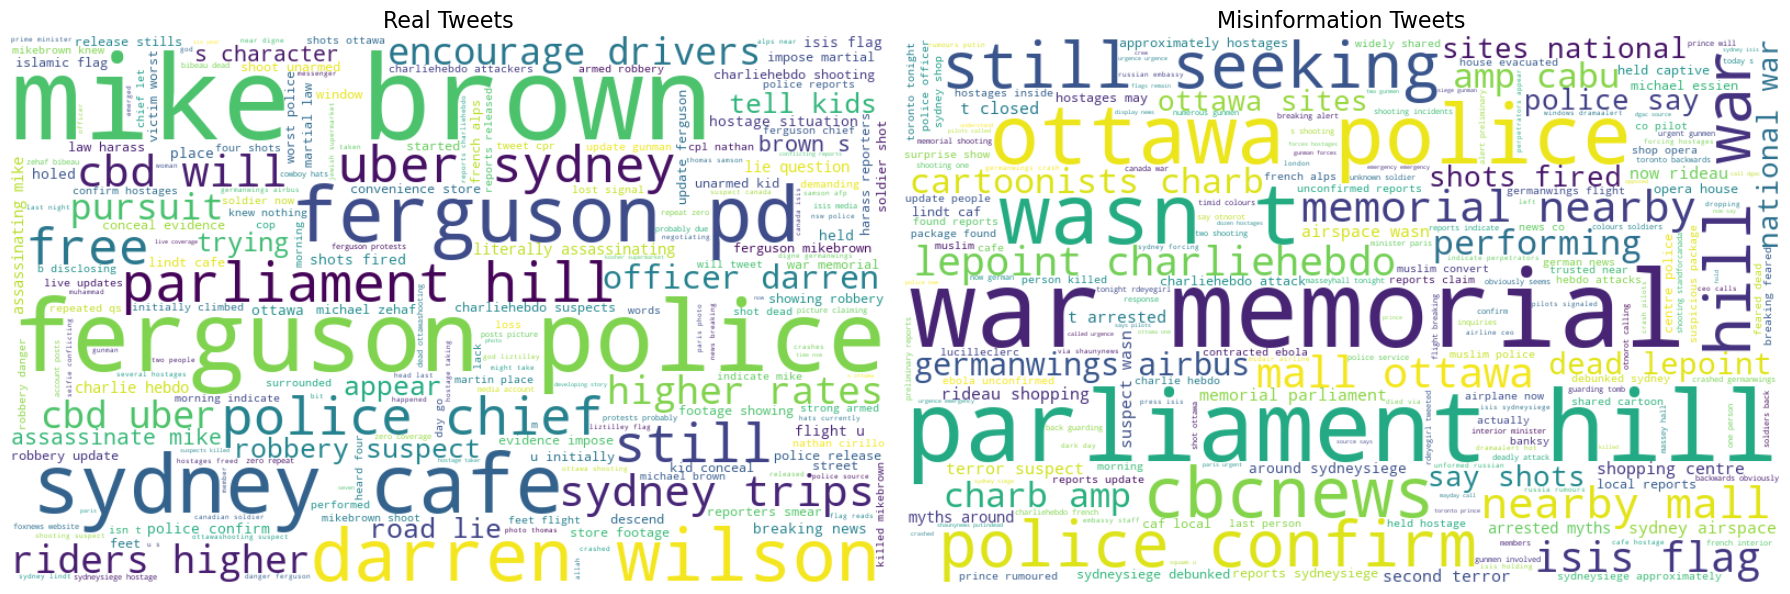

In [27]:
#We define clean_text to avoid having URLs and punctation in the word cloud
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", " ", text)    # Remove punctuation and non-letter characters
    return text.lower()                          # Convert to lowercase


real_text = " ".join(real['text'].apply(clean_text))       # Combine all cleaned real tweets into one string
misinfo_text = " ".join(misinfo['text'].apply(clean_text)) # Combine all cleaned misinformation tweets into one string

#Generating the two wrodclouds
wc_real = WordCloud(
    width=800,
    height=500,
    background_color='white',
    max_words=200
).generate(real_text)  # Generate word cloud for real tweets

wc_misinfo = WordCloud(
    width=800,
    height=500,
    background_color='white',
    max_words=200
).generate(misinfo_text)  # Generate word cloud for misinformation tweets


#Display
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Real tweets word cloud
axes[0].imshow(wc_real, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Real Tweets", fontsize=16)

# Misinformation tweets word cloud
axes[1].imshow(wc_misinfo, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Misinformation Tweets", fontsize=16)

plt.tight_layout()
plt.show()


### Hypotheses about possible relationships between disinformation and polarization

### PART 2. Text Vector Representation

In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Para Word2Vec
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Para BERT / contextual embeddings
import torch
from transformers import AutoTokenizer, AutoModel


In [29]:
# Make sure the tag is int
df['misinformation'] = df['misinformation'].astype(int)

X_text = df['text'].values
y = df['misinformation'].values

# Split 70% train, 15% val, 15% test (estratificado)
X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.3, random_state=42, stratify=y
)

X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size :", len(X_train_text))
print("Val size   :", len(X_val_text))
print("Test size  :", len(X_test_text))


Train size : 2139
Val size   : 459
Test size  : 459


In [30]:
# === TF-IDF REPRESENTATION ===

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,        
    ngram_range=(1, 2),        
    min_df=2,                  
    stop_words='english'       
)

#  with  train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

#  val y test with same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Val  :", X_val_tfidf.shape)
print("Test :", X_test_tfidf.shape)


TF-IDF shapes:
Train: (2139, 3003)
Val  : (459, 3003)
Test : (459, 3003)


In [31]:
# === WORD2VEC REPRESENTATION ===

#   tokenizar using gensim.simple_preprocess
def tokenize(text):
    
    return simple_preprocess(str(text), deacc=True)


# Tokenizamos
X_train_tokens = [tokenize(t) for t in X_train_text]
X_val_tokens   = [tokenize(t) for t in X_val_text]
X_test_tokens  = [tokenize(t) for t in X_test_text]

print(X_train_tokens[0][:20])  # first tweet


['it', 'appears', 'that', 'ferguson', 'pd', 'are', 'trying', 'to', 'assassinate', 'mike', 'brown', 'character', 'after', 'literally', 'assassinating', 'mike', 'brown']


In [32]:
# Entrenamos Word2Vec SOLO con  tokens de train
w2v_size = 100   # dimensión del embedding
w2v_window = 5
w2v_min_count = 2
w2v_workers = 4  

w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=w2v_size,
    window=w2v_window,
    min_count=w2v_min_count,
    workers=w2v_workers,
    sg=1   
)


w2v_model.save("w2v_pheme.model")
print("Tamaño vocabulario Word2Vec:", len(w2v_model.wv))


Tamaño vocabulario Word2Vec: 1274


In [33]:
def document_vector(tokens, model, vector_size):
   
    valid_tokens = [w for w in tokens if w in model.wv.key_to_index]
    if not valid_tokens:
        
        return np.zeros(vector_size)
   
    return np.mean(model.wv[valid_tokens], axis=0)


def build_w2v_features(tokenized_texts, model, vector_size):
    doc_vectors = [document_vector(tokens, model, vector_size)
                   for tokens in tokenized_texts]
    return np.vstack(doc_vectors)


X_train_w2v = build_w2v_features(X_train_tokens, w2v_model, w2v_size)
X_val_w2v   = build_w2v_features(X_val_tokens, w2v_model, w2v_size)
X_test_w2v  = build_w2v_features(X_test_tokens, w2v_model, w2v_size)

print("Word2Vec shapes:")
print("Train:", X_train_w2v.shape)
print("Val  :", X_val_w2v.shape)
print("Test :", X_test_w2v.shape)


Word2Vec shapes:
Train: (2139, 100)
Val  : (459, 100)
Test : (459, 100)


In [34]:
# === BERT / CONTEXTUAL EMBEDDINGS ===

#

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device:", device)

#bert_model_name = "distilbert-base-uncased"

#tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
#bert_model = AutoModel.from_pretrained(bert_model_name)
#bert_model.to(device)
#bert_model.eval()


Using device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L